**Authors: Francesco Mannella and Emilio Cartoni

This manuscript describes the leaky Echo-State network together with some implementations and optimizations of the inner weights of the network.


## The leaky Echo-State network

The dynamical system is a recurrent network of leaky units with a sigmoidal output function:

$
\tau\dot{\mathbf{x}} = -\mathbf{x} + \mathbf{W}\tanh\left(\mathbf{x}\right)
$

$
\mathbf{x} \in \mathbb{R}^N,  \mathbf{W} \in \mathbb{R}^{N\times N}
$

The only constraint defining echo-state networks compared to other recurrent networks is the ***ESP*** (Echo-State Property):

$
1-\epsilon <  \rho\left(\mathbf{V}\right)  < 1 
$

where $\mathbf{V}$ is the correction of the weight matrix accounting for leakyness (http://goo.gl/bqGAJu)

$
\mathbf{V} = \frac{\delta t}{\tau}\mathbf{W} + \left(1 - \frac{\delta t}{\tau}\right)\mathbf{I} 
$

and $\rho\left(\mathbf{V}\right)$ is the spectral radius of the matrix 

$
\rho\left(\mathbf{V}\right) = \max_i\left(\left|\lambda^\mathbf{V}_i \right|\right)
$

## The dynamic-rotation trick

Provided that we scale the spectral radius of the weight matrix $\mathbf{W}$ so that it fulfills the ESP clause we can initialize the weights to any set of values. 

In particular, we can modulate the ratio between the variance of the real part of the eigenvalues of $\mathbf{W}$ and the variance of their imaginary part.

For every square matrix $\mathbf{W}$ the following holds true:

$\mathbf{W} =\frac{\mathbf{W} + \mathbf{W}^T}{2} + \frac{\mathbf{W} - \mathbf{W}^T}{2}$


where

$\mathbf{W}_{sim} =\frac{\mathbf{W} + \mathbf{W}^T}{2}$

is a simmetric matrix and

$\mathbf{W}_{skew} =\frac{\mathbf{W} - \mathbf{W}^T}{2}$

is a skew matrix.

Skew matrices have pure imaginary eigenvalues.
A dynamical system having a skew matrix as its weight matrix produces only ***infinitesimal rotations***. 

On the other side simmetric matrices have pure real eigenvalues.
A dynamical system having a simmetric matrix as its weight matrix produces produces only ***infinitesimal contractions/expansions***.


Controlling the amount of infinitesimal rotation in the behaviour of a reservoir allows to increase the variability in the states of the network narrowing the distance with chaotic behaviour.
As a result the network is sensible to features at a lower time scale (Note: does it mean faster or slower time scale?) and its "memory" interval increases (Note: do we have proofs, references or examples for this?).

Knowing this we can build a new matrix

$\mathbf{W} = \alpha \mathbf{W}_{skew} + (1-\alpha)\mathbf{W}_{sim}$

where $\alpha$ is the proportion of "skewness"
of the matrix.



## Finding the inner weights $\mathbf{W}$

* [ESP: analytical method (the wrong one)](#ESP%3A-analytical-method-%28the-wrong-one%29)
* [ESP: iterative method (the right one)](#ESP%3A-iterative-method-%28the-right-one%29)
* [ESP: analytical method (the RIGHT one)](#ESP%3A-analytical-method-%28the-RIGHT-one%29)
* [Redefining our ESN according to Jaeger 2007](#Redefining-our-ESN-according-to-Jaeger-2007)

#### Common settings

In [1]:
%matplotlib inline
from pylab import *

# costants
#-------------------------------------------------------
n = 200
dt = 0.001
tau = 0.01
epsilon = 1e-60
alpha = 0.1
target = 1-epsilon
itarget = 1.0 - (epsilon/2.0)
#-------------------------------------------------------


# utils
#-------------------------------------------------------
def get_rho_and_eig(X) :
    e = eigvals(X) 
    return  max(abs(e)), e

def get_W_from_V(X) :
    return (tau/dt)*(X - (1-(dt/tau))*eye(n,n)) 

def get_V_from_W(X) :
    return (dt/tau)*X + (1-(dt/tau))*eye(n,n)

def modulate_rotation_contraction(X) :
    W1 = .5*(X-X.T)
    W2 = .5*(X+X.T)

    return alpha*W2 +(1-alpha)*W1

#-------------------------------------------------------
# create initial weights
W = randn(n, n)
W = modulate_rotation_contraction(W)
rho, e = get_rho_and_eig(W) 
3
SSW = W.copy()
# store weights scaled tho rho=1
SW = (W/rho)
print "done"

done


### ESP: analytical method (the wrong one)


* ***Init*** $\mathbf{V}$ sampling from $\mathcal{N} (m=0,\sigma=1)$
* ***Scale***  $\mathbf{V}$ so that $1 -\epsilon < \rho(\mathbf{V}) < 1$
* ***Get*** $\mathbf{W}$ from $\mathbf{V}$ : $\mathbf{W} = \frac{\tau}{\delta t}\left(\mathbf{V} - \left(1-\frac{\delta t}{\tau}\right)\mathbf{I} \right)$

#### Why it is the wrong method:
What we are really searching is a relation between the spectral radius of $\mathbf{W}$ and $\mathbf{V}$, instead we are not interested in maintaining other characteristics of $\mathbf{V}$ in $\mathbf{W}$. In particular, $\mathbf{V}$ is obtainied from $\mathbf{W}$ by scaling and translating its diagonal by a constant. Indeed multiplying a square matrix times a scalar means scaling all its eigenvalues, while trans means translating its diagonal by a costant means translating the mean of the real part of its eigenvalues. Thus the method above does a further unwanted translation $ -\frac{\tau}{\delta t}\left(1-\frac{\delta t}{\tau}\right)\mathbf{I}$. This last operation has the catastrophic effect of redefining all weights as negative.


ESP: analytical method (the wrong one)"

W
--------------------------------------
rho := 170.862374074855  
min := -24.2037  max :=  24.9223   

V
--------------------------------------
rho :=   1.000000000000  
min :=  -0.1258  max :=   0.4824   



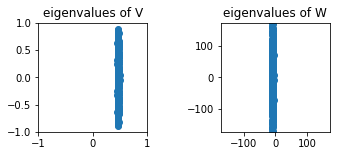

In [2]:
V = get_V_from_W(W)
rho, e = get_rho_and_eig(V) 
V = (1-epsilon/2.0)*V/rho
W = get_W_from_V(W)



figure("Method1", figsize=(6,2))
#*****************************
m_rho, m_e = get_rho_and_eig(V) 
#*****************************
subplot(121, aspect="equal")
title("eigenvalues of V")
scatter(real(m_e), imag(m_e))
xlim([-m_rho, m_rho])
ylim([-m_rho, m_rho])
#*****************************

#*****************************
rho, e = get_rho_and_eig(W) 
#*****************************
subplot(122, aspect="equal")
title("eigenvalues of W")
scatter(real(e), imag(e))
xlim([-rho, rho])
ylim([-rho, rho])
#*****************************

print """
ESP: analytical method (the wrong one)"

W
--------------------------------------
rho := {:16.12f}  
min := {:8.4f}  max := {:8.4f}   

V
--------------------------------------
rho := {:16.12f}  
min := {:8.4f}  max := {:8.4f}   
""".format(rho, W.min(), W.max(), 
           m_rho, V.min(), V.max())

### ESP: iterative method (the right one)

* ***Init*** $\mathbf{SW}$ sampling from $\mathcal{N} (m=0,\sigma=1)$
* ***Scale***  $\mathbf{SW}$ so that $\rho(\mathbf{SW}) = 1$
* *** Do ***
    * ***choose*** an estimate $\hat{\rho}$
    * ***scale*** to  $\mathbf{W} = \hat{\rho}\mathbf{SW}$
    * ***compute*** $\mathbf{V} = \frac{\delta t}{\tau}\mathbf{W} + \left(1 - \frac{\delta t}{\tau}\right)\mathbf{I}$
* *** while *** not $(1-\epsilon < \rho(\mathbf{V}) < 1)$ 

We can optimize the search using a root-finding method (e.g the [bisection](https://en.wikipedia.org/wiki/Bisection_method) method )

***PROS***: This method finds the correct $\hat{\rho} = \rho{(\mathbf{W})}$ because it searches only in the space of the spectral radii of $\mathbf{W}$. Instead, $\rho(\mathbf{V})$ is only used as a parameter of the objective function of any choosen root-finding iterative method.

***CONS***: This method can be computationally expensive. In particular, the smaller we choose $\epsilon$ the longer it takes (more iterations) to find the solution.



computed in 35.494968s



ESP: iterative method
W
--------------------------------------
rho :=   4.412940892325  
min :=  -0.6262  max :=   0.6448   

V 
--------------------------------------
rho :=   1.000000000000  
min :=  -0.0626  max :=   0.9072   



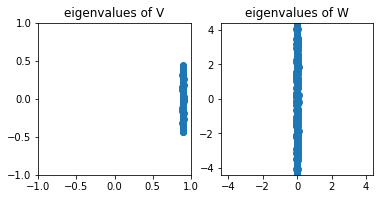

In [3]:
from scipy.optimize import bisect

def dist(rho_estimate) :
    V = get_V_from_W(rho_estimate*SW)
    effective_rho_estimate,_ = get_rho_and_eig(V)
    return itarget - effective_rho_estimate

import time
start = time.clock()

# ---------------------------------------------------------------
rho_estimate = bisect(lambda x: dist(x), 
                      1-epsilon, tau/dt, 
                      xtol = epsilon/2.)
# ---------------------------------------------------------------

print
print
print "computed in {}s".format(time.clock() - start)
print 
print

W = SW*rho_estimate
V = get_V_from_W(W)

figure("Method2")
#*****************************
m_rho, m_e = get_rho_and_eig(V) 
#*****************************
subplot(121, aspect="equal")
title("eigenvalues of V")
scatter(real(m_e), imag(m_e))
xlim([-m_rho, m_rho])
ylim([-m_rho, m_rho])
#*****************************

#*****************************
rho, e = get_rho_and_eig(W) 
#*****************************
subplot(122, aspect="equal")
title("eigenvalues of W")
scatter(real(e), imag(e))
xlim([-rho, rho])
ylim([-rho, rho])
#*****************************

print """
ESP: iterative method
W
--------------------------------------
rho := {:16.12f}  
min := {:8.4f}  max := {:8.4f}   

V 
--------------------------------------
rho := {:16.12f}  
min := {:8.4f}  max := {:8.4f}   
""".format(rho, W.min(), W.max(), 
           m_rho, V.min(), V.max())

### ESP: analytical method (the RIGHT one)

Given that

$\mathbf{V} = \frac{\delta t}{\tau}\hat{\rho}\mathbf{SW} + \left(1 - \frac{\delta t}{\tau}\right)\mathbf{I}$

where

$\left\{\mathbf{SW}\mid\mathbf{SW}\in\mathbb{R}^{n\times  n}\wedge\rho(\mathbf{SW}) = 1\right\}$

$\left\{\hat{\rho}\mid  \hat{\rho}\in \mathbb{R}_{>0}\wedge \rho(\mathbf{V}) = 1-\frac{\epsilon}{2}\right\}$

and $(\mathbf{v}\circ\mathbf{v})$ is the [Hadamard product
](https://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29#Definition).


The vector of eigenvalues of $\mathbf{V}$ is

$\mathbf{\Lambda}^V = (\lambda^V_0,\lambda^V_1\dots\lambda^V_n)$ 

And we can write the absolute values of the eigenvalues as

$
\begin{align}
\left|\mathbf{\Lambda}^V\right| = \sqrt{ \left(h\mathbf{k}\circ\mathbf{x} + \left(1-h\right)\right)^2 + \left(h\mathbf{k} \circ\mathbf{y}\right)^2 }& 
\end{align}
$

where

$h = \frac{\delta t}{\tau}$

$\mathbf{x} = \operatorname{Re}(\mathbf{\Lambda}^V)$

$\mathbf{y} = \operatorname{Im}(\mathbf{\Lambda}^V)$ 

$\mathbf{k} = \hat{\rho}\mathbf{1}_n$ 


Now we can think $\mathbf{k}$ as a vector of unknown values and
solve for $\mathbf{k}$ the following equation:

$\left|\mathbf{\Lambda}^V\right| =  (1 -\frac{\epsilon}{2})\mathbf{1}_n $

$
\left|\mathbf{\Lambda}^V\right| - (1-\frac{\epsilon}{2})\mathbf{1}_n = 0 
$

$
\left(\mathbf{x}^2h^2+\mathbf{y}^2h^2\right)\circ\mathbf{k}^{\circ2} + 
\left(2\mathbf{x}h-2\mathbf{x}h^2\right)\circ\mathbf{k} + \left(1+h^2-2h-
\left(1-\frac{\epsilon}{2}\right)^2\mathbf{1}_n\right) = 0
$

where $\mathbf{v}^{\circ2}$ is the [Hadamard power](https://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29#Analogous_operations).


Since this is a quadratic equation we will have two sets of solutions. 
We choose as the correct solution the right edge of the intersection 
between all the n equations, within which interval all eigenvalue modules are less 
than $1 -\frac{\epsilon}{2}$ (red area in the picture below). 
The chosen solution (red dot in the figure) ensures that at least one
of the eigenvalues is exactly $1 -\frac{\epsilon}{2}$ and that 
this is also the maximum absolute eigenvalue (spectral radius) since 
all other values are also $1 -\frac{\epsilon}{2}$ (if they share a solution
in that point) or less than $1 -\frac{\epsilon}{2}$.


<img src="pics/intersection.svg" width="600">



computed in 0.612013s



ESP: analytical method (the RIGHT one)
W
--------------------------------------
rho :=   4.412940892325  
min :=  -0.6262  max :=   0.6448   

V 
--------------------------------
rho :=   1.000000000000  
min :=  -0.0626  max :=   0.9072   



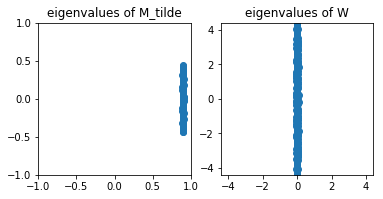

In [4]:
target = 1 - epsilon/2.

W = SW.copy()

#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
start = time.clock()

# --------------------------------------------------

rho, e = get_rho_and_eig(W) 
x = e.real
y = e.imag
h = dt/tau
a = x**2*h**2 + y**2*h**2
b = 2*x*h - 2*x*h**2
c = 1 + h**2 - 2*h - target**2

# just get the positive solutions
sol2 = (-b + sqrt(b**2 - 4*a*c))/(2*a)
# and take the minor amongst them
correctRhoMultiplier = min(sol2)
W = correctRhoMultiplier*W
# --------------------------------------------------
print
print
print "computed in {}s".format(time.clock() - start)
print 
print

#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§

V = get_V_from_W(W)

figure("Method3")
#*****************************
m_rho, m_e = get_rho_and_eig(V)
#*****************************
subplot(121, aspect="equal")
title("eigenvalues of M_tilde")
scatter(real(m_e), imag(m_e))
xlim([-m_rho, m_rho])
ylim([-m_rho, m_rho])
#*****************************

#*****************************
rho, e = get_rho_and_eig(W)
#*****************************
subplot(122, aspect="equal")
title("eigenvalues of W")
scatter(real(e), imag(e))
xlim([-rho, rho])
ylim([-rho, rho])
#*****************************
print """
ESP: analytical method (the RIGHT one)
W
--------------------------------------
rho := {:16.12f}  
min := {:8.4f}  max := {:8.4f}   

V 
--------------------------------
rho := {:16.12f}  
min := {:8.4f}  max := {:8.4f}   
""".format(rho, W.min(), W.max(), 
           m_rho, V.min(), V.max())


### Redefining our ESN according to Jaeger 2007

Our ESN has the following update:

$\dot{x_f} = -hx_f+h(I+\rho_fWf(x_f))$

while Jaeger's has the following:

$\dot{x_j} = -a_jx_j+f(I+\rho_jWx_j)$

The presence of $h$ multiplying the activation function f in our update makes it impossible to replicate our network using Jaeger's equation, unless h = 1.
However, it is possible to define Jaeger's parameters $a_j$ and $\rho_j$ so that Jaeger's network will follow the same dynamics of our network, scaled by a factor h.

If $a_j = h$ and $\rho_j = h\rho_f$ then Jaeger's update will be:

$x_j = -hx_j+f(I+h\rho_fWx_j)$

This will produce a network with the same dynamics as our network, but the internal states $x_j$ will be $1/h$ of our network states $x_f$ (so if $h = 0.1$ they will be 1/0.1 = 10 times larger).

See code below for numerical proof.



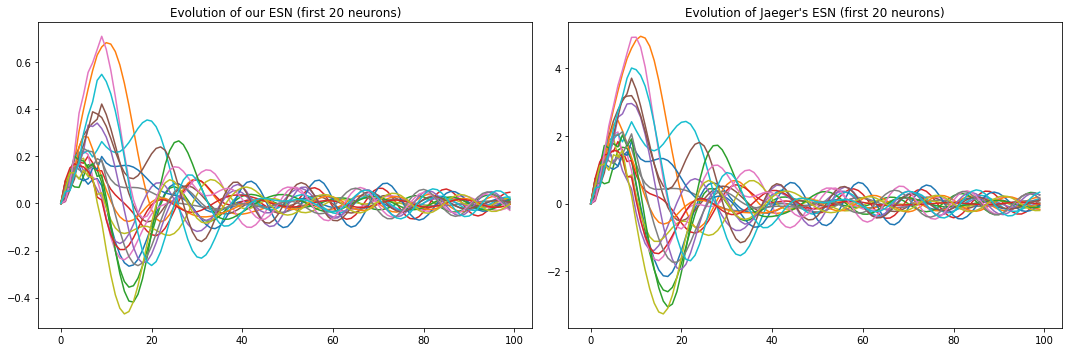

In [6]:
T = 100
n_test = 20
u = zeros([n,T])
u[:,:10] = np.random.rand(n,10)

x_f = np.zeros((n,T))
x_j = np.zeros((n,T))
x_f[:,0] = 0
x_j[:,0] = 0
for t in range(1,T):
    x_f[:,t] = x_f[:,t-1]-h*x_f[:,t-1]+h*(u[:,t]+W.dot(tanh(x_f[:,t-1])))
    x_j[:,t] = x_j[:,t-1]-h*x_j[:,t-1]+tanh(u[:,t]+h*W.dot(x_j[:,t-1]))

figure("ESN Comparison: same dynamics but 1/h times wider h = %f" % h, figsize=(15,5))
subplot(121)#, aspect="equal")
title("Evolution of our ESN (first %i neurons)" % n_test)
plot(x_f[0:n_test,:].T)

subplot(122)#, aspect="equal")
title("Evolution of Jaeger's ESN (first %i neurons)" % n_test)
plot(x_j[0:n_test,:].T)

tight_layout()
